In [1]:
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import re

In [5]:
dir_name='duplicate'

In [7]:
local_plot=common_utils.load_db(dir_name,'local.plot.tfidf')

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/local.plot.tfidf.csv,  index False


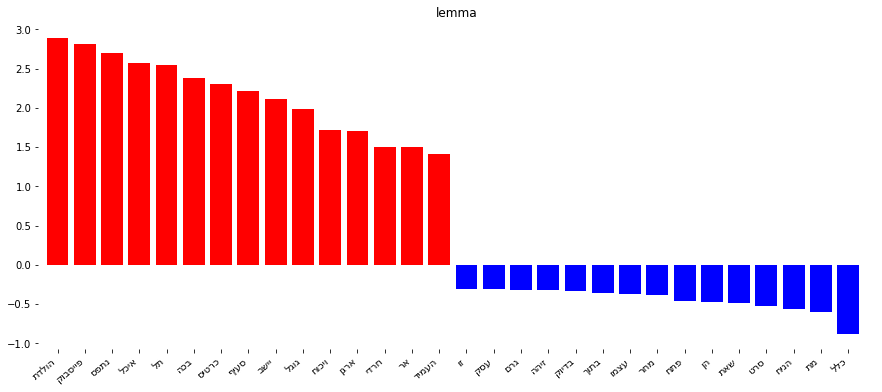

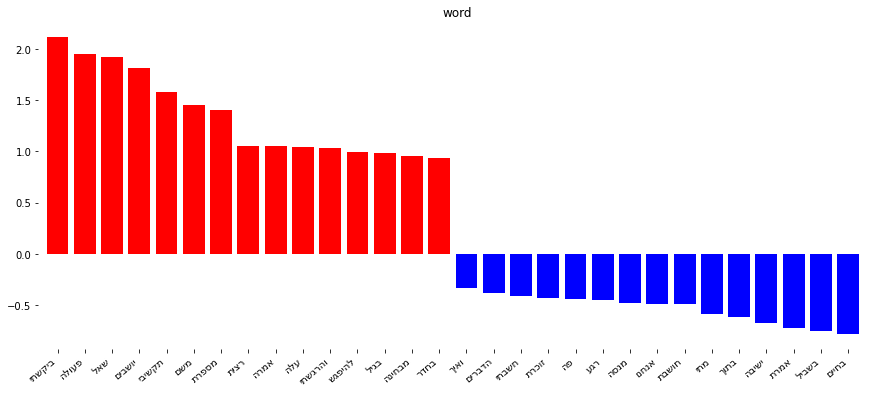

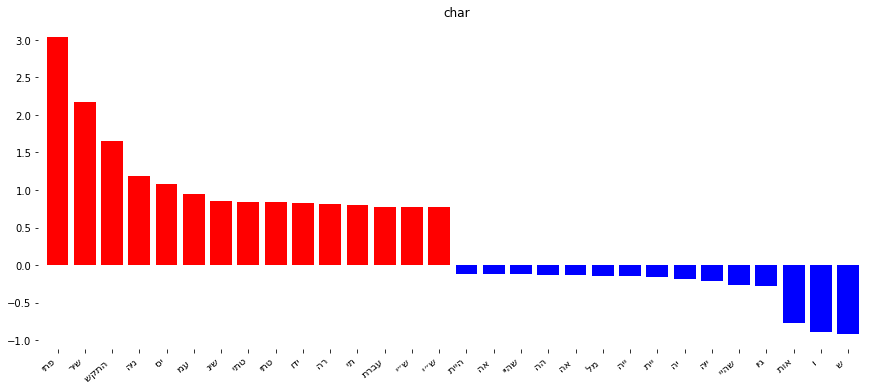

In [8]:
imp.reload(model_utils)
for tt in ['lemma','word','char']:
    plt.figure(figsize=(15, 6))
    ax=model_utils.plot_important_features(tt,local_plot['weight.{}.is_nar'.format(tt)].tolist(), local_plot['string.{}.is_nar'.format(tt)].tolist(), top_n=15, rotation=40)
    plt.show()